# End-to-End Incremental Training Image Classification Example with Experiment

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Training the model](#Training-the-model)
  1. [Training parameters](#Training-parameters)
  2. [Start the training](#Start-the-training)
4. [Inference](#Inference)

_본 예제는 [Amazon SageMaker Examples](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-incremental-training-highlevel.ipynb) 를 참고하였습니다._

## Introduction

Amazon Sagemaker image classificaiton 알고리즘을 사용한 incremental training 의 end to end 예제에 오신 것을 환영합니다. 이 데모에서는 Amazon SageMaker image classification 알고리즘을 사용하여 [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) 을 training 합니다. 처음에는 몇번의 epoch 을 실행하여 training 하고, 그 이후에 이전 교육에서 생성된 모델을 사용하여 다시 훈련하지 않고 정확도를 높이기 위해 추가된 데이터만을 사용해 또 다른 training 을 시작합니다. 

시작하기에 앞서 권한, 구성 등에 대한 몇 가지 사전 요구 사항 단계를 통해 환경을 설정해야 합니다.

## Prequisites and Preprocessing

### Permissions and environment variables

여기서는 AWS 서비스에 대한 연결 및 인증을 설정합니다. 다음 세가지 부분을 참조합니다.

* 데이터에 대한 학습 및 호스팅 액세스 권한을 부여하는 데 사용되는 Role. 이 작업은 노트북을 시작하는 데 사용된 Role 에서 자동으로 얻어집니다.
* 학습 및 모델 데이터에 사용할 S3 버킷
* 변경할 필요가 없는 Amazon SagegMaker image classification 도커 이미지

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
# TODO: default 버킷 대신 사용자 지정 버킷을 사용하도록 하고 prefix 역시 사용자 지정 prefix 를 사용하도록 합니다.
bucket = sess.default_bucket()
prefix = "ic-fulltraining"

arn:aws:iam::806174985048:role/service-role/AmazonSageMaker-ExecutionRole-20201218T151409
CPU times: user 1.41 s, sys: 931 ms, total: 2.34 s
Wall time: 824 ms


image classification 도커 이미지를 위한 주소를 지정합니다.

In [2]:
from sagemaker import analytics

In [3]:
import pandas as pd

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# from sagemaker.amazon.amazon_estimator import get_image_uri

# training_image = get_image_uri(sess.boto_region_name, "image-classification", repo_version="latest")
training_image = sagemaker.image_uris.retrieve("image-classification", sess.boto_region_name)

In [6]:
training_image

'306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/image-classification:1'

### Data preparation

데이터를 다운로드하고 S3로 전송하여 학습에 사용합니다. 이 데모에서는 256개 객체의 이미지를 30608개 포함하는 [Caltech-256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) 데이터 세트를 사용하고 있습니다. 학습 및 유효성 검사 데이터의 경우 이 MXNet [example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/data/caltech256.sh) 의 분할 체계를 따릅니다. 특히 학습을 위해 클래스당 60개의 이미지를 무작위로 선택하고 나머지 데이터를 검증에 사용합니다. 알고리즘은 `RecordIO` 포멧을 입력으로 사용합니다. 이미지 파일을 입력으로 사용 할 수도 있는데 이 파일은 MXNet의 [im2rec](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) 툴을 사용하여 `RecordIO` 형식으로 변환됩니다. p2.xlarge 인스턴스에서 전체 Caltech-256 데이터 세트 (약 1.2GB) 를 변환하는 데 약 50초가 걸립니다. 이 데모에서는 RecordIO 형식을 사용합니다. 

In [7]:
import boto3

s3_client = boto3.client("s3")


def upload_to_s3(channel, file):
    s3 = boto3.resource("s3")
    data = open(file, "rb")
    key = channel + "/" + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
s3_client.download_file(
    "sagemaker-sample-files",
    "datasets/image/caltech-256/caltech-256-60-train.rec",
    "caltech-256-60-train.rec",
)
s3_client.download_file(
    "sagemaker-sample-files",
    "datasets/image/caltech-256/caltech-256-60-val.rec",
    "caltech-256-60-val.rec",
)

In [8]:
# Two channels: train, validation
s3train = "s3://{}/{}/train/".format(bucket, prefix)
s3validation = "s3://{}/{}/validation/".format(bucket, prefix)

In [9]:
# upload the rec files to train and validation channels
!aws s3 cp caltech-256-60-train.rec $s3train
!aws s3 cp caltech-256-60-val.rec $s3validation --quiet

upload: ./caltech-256-60-train.rec to s3://sagemaker-ap-northeast-2-806174985048/ic-fulltraining/train/caltech-256-60-train.rec


올바른 학습 포멧으로 데이터를 사용할 수 있게 되면 다음 단계는 데이터를 사용하여 모델을 실제로 학습시키는 것입니다. 학습 parameter 를 설정한 후 학습을 시작하고 학습이 완료될 때까지 상태를 폴링합니다.

## Training the model

필요한 모든 설정을 완료했으므로 이제 object detector 를 훈련시킬 준비가 되었습니다. 시작하려면 ``sageMaker.estimator.Estimator`` 객체를 만들어 보겠습니다.이 estimator 는 학습 작업을 시작합니다.

### Training parameters

학습을 위해 설정해야 하는 매개변수에는 두 가지 종류가 있습니다. 첫번째는 학습 작업의 매개 변수입니다. 여기에는 다음이 포함됩니다.

* **Training instance count**: 이 개수는 학습을 실행할 인스턴스의 갯수입니다. 인스턴스 수가 1보다 크면 image classification 알고리즘이 분산 학습 모드에서 실행됩니다. 
* **Training instance type**: 이는 학습을 실행할 컴퓨팅 머신 유형을 나타냅니다. 일반적으로 이러한 학습에는 GPU 인스턴스를 사용합니다. 
* **Output path**: 학습 이후 output 이 저장되는 s3 폴더입니다.


In [12]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

위의 매개 변수 집합 외에도 알고리즘과 관련된 하이퍼파라미터가 있습니다. 다음과 같습니다.

* **num_layers**: 네트워크의 레이어 수 (깊이) 입니다. 이 샘플에는 18을 사용하지만 50, 152와 같은 다른 값을 사용할 수 있습니다.
* **image_shape**: 네트워크의 입력 이미지 dimension, 'num_channels, 높이, 너비' 입니다. 실제 이미지 크기보다 크지 않아야 합니다. 채널 숫자는 실제 이미지와 같아야 합니다.
* **num_classes**: 새 데이터 셋에 대한 출력 클래스 수입니다. Imagenet은 1000개의 출력 클래스로 훈련되었지만 미세 조정을 위해 출력 클래스 수를 변경할 수 있습니다. caltech의 경우 257을 사용합니다. 256개의 객체 범주+1개의 클러터 클래스가 있기 때문입니다.
* **num_training_samples**: 총 교육 샘플 수입니다.현재 분할이 있는 caltech 데이터 세트의 경우 15240으로 설정됩니다.
* **mini_batch_size**: 각 미니 배치에 사용되는 훈련 샘플 수입니다. 분산 훈련에서 배치당 사용되는 훈련 샘플 수는 N * mini_batch_size 가 됩니다. 여기서 N은 훈련이 실행되는 호스트 수입니다.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: 훈련 중 상위 k 정확도를 보고합니다.


In [13]:
ic.set_hyperparameters(
    num_layers=18,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=256,
    epochs=2,
    learning_rate=0.1,
    top_k=2,
)

## Input data specification
학습에 사용되는 데이터 유형 및 채널 설정

In [14]:
train_data = sagemaker.inputs.TrainingInput(
    s3train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

### Experiment

### Install Python SDKs

In [15]:
import sys

In [16]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [17]:
import time

In [18]:
from IPython.display import set_matplotlib_formats

from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

### initial training experiment

In [19]:
caltech_experiment = Experiment.create(
    experiment_name=f"image-classification-caltech-256-{int(time.time())}",
    description="Classification of caltech 256 dataset",
)
print(caltech_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7efd0fd95908>,experiment_name='image-classification-caltech-256-1628727493',description='Classification of caltech 256 dataset',tags=None,experiment_arn='arn:aws:sagemaker:ap-northeast-2:806174985048:experiment/image-classification-caltech-256-1628727493',response_metadata={'RequestId': 'c229b20f-d9e0-4a87-8110-bfd14fe47f87', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c229b20f-d9e0-4a87-8110-bfd14fe47f87', 'content-type': 'application/x-amz-json-1.1', 'content-length': '120', 'date': 'Thu, 12 Aug 2021 00:18:13 GMT'}, 'RetryAttempts': 0})


In [20]:
caltech_trial = caltech_experiment.create_trial(trial_name=f'image-classification-caltech-256-first-{int(time.time())}')

## Start the training
Estimator 에서 fit 메서드를 호출하여 학습을 시작합니다.

In [21]:
%%time
ic.fit(inputs=data_channels, logs=True, experiment_config={
            "ExperimentName": caltech_experiment.experiment_name,
            "TrialName": caltech_trial.trial_name,
            "TrialComponentDisplayName": "caltech-image-classification",
        })

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: image-classification-2021-08-12-00-18-39-481


2021-08-12 00:18:39 Starting - Starting the training job...
2021-08-12 00:18:47 Starting - Launching requested ML instancesProfilerReport-1628727519: InProgress
......
2021-08-12 00:20:08 Starting - Preparing the instances for training............
2021-08-12 00:22:02 Downloading - Downloading input data...
2021-08-12 00:22:34 Training - Downloading the training image........Docker entrypoint called with argument(s): train
[08/12/2021 00:23:51 INFO 139772794767168] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[08/12/2021 00:23:51 INFO 139772794767168] Merging with provided configuration from /opt/ml/input/config

Experiment 분석을 위한 Analytics 를 만듭니다.

In [22]:
trial_component_analytics = analytics.ExperimentAnalytics(experiment_name=caltech_experiment.experiment_name)

In [23]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,epochs,image_shape,learning_rate,mini_batch_size,num_classes,num_layers,num_training_samples,top_k,validation:accuracy:epoch - Min,validation:accuracy:epoch - Max,validation:accuracy:epoch - Avg,validation:accuracy:epoch - StdDev,validation:accuracy:epoch - Last,validation:accuracy:epoch - Count,train:accuracy:epoch - Min,train:accuracy:epoch - Max,train:accuracy:epoch - Avg,train:accuracy:epoch - StdDev,train:accuracy:epoch - Last,train:accuracy:epoch - Count,validation:accuracy - Min,validation:accuracy - Max,validation:accuracy - Avg,validation:accuracy - StdDev,validation:accuracy - Last,validation:accuracy - Count,train:accuracy - Min,train:accuracy - Max,train:accuracy - Avg,train:accuracy - StdDev,train:accuracy - Last,train:accuracy - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,image-classification-2021-08-12-00-18-39-481-a...,caltech-image-classification,arn:aws:sagemaker:ap-northeast-2:806174985048:...,306986355934.dkr.ecr.ap-northeast-2.amazonaws....,1.0,ml.p2.xlarge,50.0,2.0,"3,224,224",0.1,256.0,257.0,18.0,15420.0,2.0,0.061068,0.083157,0.072112,0.015619,0.083157,2,0.028451,0.080208,0.05433,0.036598,0.080208,2,0.061068,0.083157,0.072112,0.015619,0.083157,2,0.028451,0.080208,0.05433,0.036598,0.080208,2,application/x-recordio,s3://sagemaker-ap-northeast-2-806174985048/ic-...,application/x-recordio,s3://sagemaker-ap-northeast-2-806174985048/ic-...,None,s3://sagemaker-ap-northeast-2-806174985048/ic-...,[image-classification-caltech-256-first-162872...,[image-classification-caltech-256-1628727493]


이제 훈련된 모델을 사용하여 추론을 수행할 수 있습니다. Estimator 에서 deploy 메서드를 사용하여 생성된 모델을 배포할 수 있습니다.

In [24]:
%%time
ic_classifier = ic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: image-classification-2021-08-12-00-30-37-094
INFO:sagemaker:Creating endpoint with name image-classification-2021-08-12-00-30-37-094


-----------------!CPU times: user 230 ms, sys: 8.39 ms, total: 238 ms
Wall time: 8min 32s


### Download test image

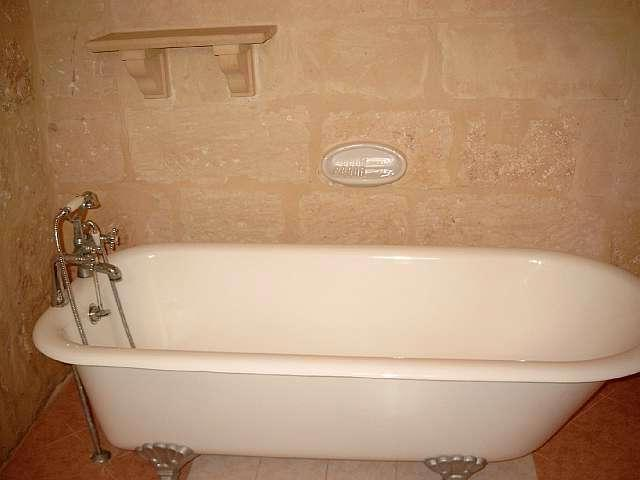

In [28]:
file_name = "/tmp/test.jpg"
s3_client.download_file(
    "sagemaker-sample-files",
    "datasets/image/caltech-256/256_ObjectCategories/008.bathtub/008_0007.jpg",
    file_name,
)
# test image
from IPython.display import Image

Image(file_name)

### Evaluation

엔드포인트를 통해 이미지의 추론을 평가합니다. 추론 모델은 클래스 확률을 출력하며 일반적으로 최대 확률을 가진 클래스를 최종 클래스 출력으로 선택합니다. 훈련 매개변수 및 하이퍼 파라미터에 따라 결과는 달라질 수 있습니다.

In [31]:
import json
import numpy as np
from sagemaker.serializers import IdentitySerializer

with open(file_name, "rb") as f:
    payload = f.read()

ic_classifier.serializer = IdentitySerializer("image/jpeg")
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = [
    "ak47",
    "american-flag",
    "backpack",
    "baseball-bat",
    "baseball-glove",
    "basketball-hoop",
    "bat",
    "bathtub",
    "bear",
    "beer-mug",
    "billiards",
    "binoculars",
    "birdbath",
    "blimp",
    "bonsai-101",
    "boom-box",
    "bowling-ball",
    "bowling-pin",
    "boxing-glove",
    "brain-101",
    "breadmaker",
    "buddha-101",
    "bulldozer",
    "butterfly",
    "cactus",
    "cake",
    "calculator",
    "camel",
    "cannon",
    "canoe",
    "car-tire",
    "cartman",
    "cd",
    "centipede",
    "cereal-box",
    "chandelier-101",
    "chess-board",
    "chimp",
    "chopsticks",
    "cockroach",
    "coffee-mug",
    "coffin",
    "coin",
    "comet",
    "computer-keyboard",
    "computer-monitor",
    "computer-mouse",
    "conch",
    "cormorant",
    "covered-wagon",
    "cowboy-hat",
    "crab-101",
    "desk-globe",
    "diamond-ring",
    "dice",
    "dog",
    "dolphin-101",
    "doorknob",
    "drinking-straw",
    "duck",
    "dumb-bell",
    "eiffel-tower",
    "electric-guitar-101",
    "elephant-101",
    "elk",
    "ewer-101",
    "eyeglasses",
    "fern",
    "fighter-jet",
    "fire-extinguisher",
    "fire-hydrant",
    "fire-truck",
    "fireworks",
    "flashlight",
    "floppy-disk",
    "football-helmet",
    "french-horn",
    "fried-egg",
    "frisbee",
    "frog",
    "frying-pan",
    "galaxy",
    "gas-pump",
    "giraffe",
    "goat",
    "golden-gate-bridge",
    "goldfish",
    "golf-ball",
    "goose",
    "gorilla",
    "grand-piano-101",
    "grapes",
    "grasshopper",
    "guitar-pick",
    "hamburger",
    "hammock",
    "harmonica",
    "harp",
    "harpsichord",
    "hawksbill-101",
    "head-phones",
    "helicopter-101",
    "hibiscus",
    "homer-simpson",
    "horse",
    "horseshoe-crab",
    "hot-air-balloon",
    "hot-dog",
    "hot-tub",
    "hourglass",
    "house-fly",
    "human-skeleton",
    "hummingbird",
    "ibis-101",
    "ice-cream-cone",
    "iguana",
    "ipod",
    "iris",
    "jesus-christ",
    "joy-stick",
    "kangaroo-101",
    "kayak",
    "ketch-101",
    "killer-whale",
    "knife",
    "ladder",
    "laptop-101",
    "lathe",
    "leopards-101",
    "license-plate",
    "lightbulb",
    "light-house",
    "lightning",
    "llama-101",
    "mailbox",
    "mandolin",
    "mars",
    "mattress",
    "megaphone",
    "menorah-101",
    "microscope",
    "microwave",
    "minaret",
    "minotaur",
    "motorbikes-101",
    "mountain-bike",
    "mushroom",
    "mussels",
    "necktie",
    "octopus",
    "ostrich",
    "owl",
    "palm-pilot",
    "palm-tree",
    "paperclip",
    "paper-shredder",
    "pci-card",
    "penguin",
    "people",
    "pez-dispenser",
    "photocopier",
    "picnic-table",
    "playing-card",
    "porcupine",
    "pram",
    "praying-mantis",
    "pyramid",
    "raccoon",
    "radio-telescope",
    "rainbow",
    "refrigerator",
    "revolver-101",
    "rifle",
    "rotary-phone",
    "roulette-wheel",
    "saddle",
    "saturn",
    "school-bus",
    "scorpion-101",
    "screwdriver",
    "segway",
    "self-propelled-lawn-mower",
    "sextant",
    "sheet-music",
    "skateboard",
    "skunk",
    "skyscraper",
    "smokestack",
    "snail",
    "snake",
    "sneaker",
    "snowmobile",
    "soccer-ball",
    "socks",
    "soda-can",
    "spaghetti",
    "speed-boat",
    "spider",
    "spoon",
    "stained-glass",
    "starfish-101",
    "steering-wheel",
    "stirrups",
    "sunflower-101",
    "superman",
    "sushi",
    "swan",
    "swiss-army-knife",
    "sword",
    "syringe",
    "tambourine",
    "teapot",
    "teddy-bear",
    "teepee",
    "telephone-box",
    "tennis-ball",
    "tennis-court",
    "tennis-racket",
    "theodolite",
    "toaster",
    "tomato",
    "tombstone",
    "top-hat",
    "touring-bike",
    "tower-pisa",
    "traffic-light",
    "treadmill",
    "triceratops",
    "tricycle",
    "trilobite-101",
    "tripod",
    "t-shirt",
    "tuning-fork",
    "tweezer",
    "umbrella-101",
    "unicorn",
    "vcr",
    "video-projector",
    "washing-machine",
    "watch-101",
    "waterfall",
    "watermelon",
    "welding-mask",
    "wheelbarrow",
    "windmill",
    "wine-bottle",
    "xylophone",
    "yarmulke",
    "yo-yo",
    "zebra",
    "airplanes-101",
    "car-side-101",
    "faces-easy-101",
    "greyhound",
    "tennis-shoes",
    "toad",
    "clutter",
]
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - rainbow, probability - 0.11248317360877991


In [32]:
object_categories[np.argsort(result)[-2]]

'mattress'

## Prepare for incremental training

이제 이전 학습에서 생성된 모델을 사용하여 동일한 데이터셋으로 다른 학습을 시작합니다. 이 새로운 학습은 이전 학습에서 생성된 모델을 사용하므로 더 높은 정확도로 시작됩니다. 

In [33]:
# Print the location of the model data from previous training
print(ic.model_data)

# Prepare model channel in addition to train and validation
model_data = sagemaker.inputs.TrainingInput(
    ic.model_data,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
    content_type="application/x-sagemaker-model",
)

data_channels = {"train": train_data, "validation": validation_data, "model": model_data}

s3://sagemaker-ap-northeast-2-806174985048/ic-fulltraining/output/image-classification-2021-08-12-00-18-39-481/output/model.tar.gz


## Start another training

이전과 동일한 하이퍼파라미터를 사용합니다. 모델 채널이 있으면 use_pretrained_model 매개변수가 무시됩니다. 클래스 수, 입력 이미지 모양 및 레이어 수는 동일한 모델로 시작하므로 이전 학습과 같아야 합니다. learning_rate, mini_batch_size 등과 같은 다른 파라미터는 다양할 수 있습니다. 

In [34]:
caltech_incr_trial = caltech_experiment.create_trial(trial_name=f'image-classification-caltech-256-second-{int(time.time())}')

In [ ]:
%%time
incr_ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)
incr_ic.set_hyperparameters(
    num_layers=18,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=2,
    learning_rate=0.01,
    top_k=2,
)

incr_ic.fit(inputs=data_channels, logs=True, experiment_config={
            "ExperimentName": caltech_experiment.experiment_name,
            "TrialName": caltech_incr_trial.trial_name,
            "TrialComponentDisplayName": "caltech-image-classification-incr",
        })

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: image-classification-2021-08-12-00-54-21-170


2021-08-12 00:54:21 Starting - Starting the training job...
2021-08-12 00:54:44 Starting - Launching requested ML instancesProfilerReport-1628729661: InProgress
.

In [ ]:
trial_component_analytics = analytics.ExperimentAnalytics(experiment_name=caltech_experiment.experiment_name)

In [ ]:
trial_component_analytics.dataframe()

In [ ]:
%%time
ic_classifier_v2 = incr_ic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
ic_classifier_v2.serializer = IdentitySerializer("image/jpeg")
result_v2 = json.loads(ic_classifier_v2.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index_v2 = np.argmax(result_v2)

In [ ]:
print("Result: label - " + object_categories[index_v2] + ", probability - " + str(result_v2[index_v2]))

In [ ]:
object_categories[np.argsort(result_v2)[-2]]